In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 读取数据集
data = pd.read_csv("/root/2023mcm/new_data.csv")

from pykalman import KalmanFilter
# 选取需要处理的列
cols = [6, 7, 8, 9, 10, 11, 12]
data_sub = data.iloc[:, cols].values

# 创建Kalman滤波器
kf = KalmanFilter(initial_state_mean=data_sub[0], n_dim_obs=7)
# 进行滤波
filtered_state_means, filtered_state_covariances = kf.filter(data_sub)

# 将滤波结果保存回原数据中
data.iloc[:, cols] = filtered_state_means

# 准备数据集
X = data.iloc[:, [1,12, 13, 14, 15, 16, 17, 19,20,21]].values
y = data.iloc[:, 5:12].values
scaler_X = MinMaxScaler()
scaler_y=MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化随机森林模型
model = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_leaf=2,min_samples_split=2,random_state=42)
# 训练模型
model.fit(X_train, y_train)

# 评估模型
train_loss = np.sqrt(np.mean((model.predict(X_train) - y_train)**2))
test_loss = np.sqrt(np.mean((model.predict(X_test) - y_test)**2))

# 打印损失
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Train Loss: 0.0804, Test Loss: 0.1351


In [11]:
from sklearn.model_selection import GridSearchCV

# 定义参数范围
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}

# 定义GridSearchCV对象
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5,n_jobs=1)

# 训练模型
grid_search.fit(X_train, y_train)

# 获取最优参数
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


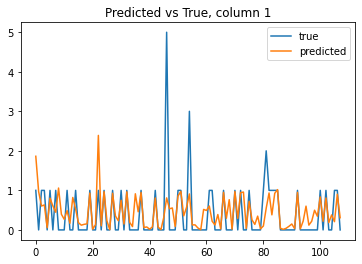

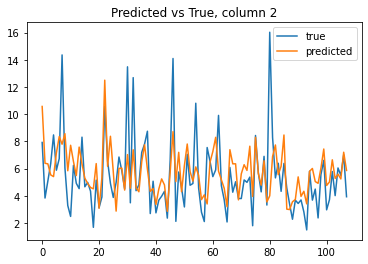

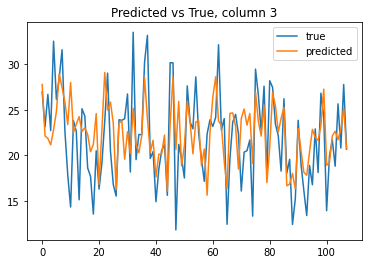

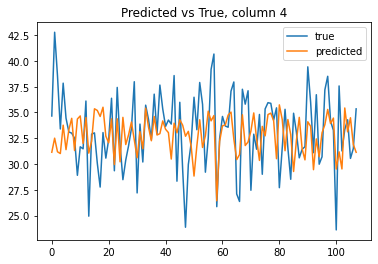

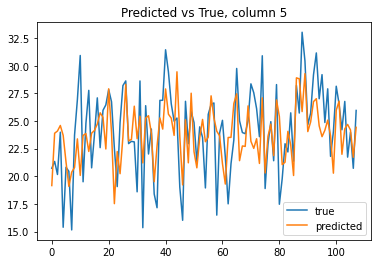

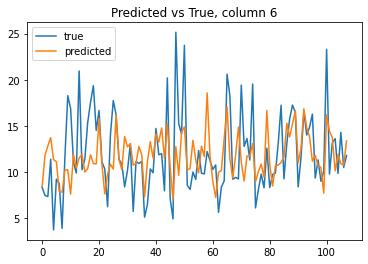

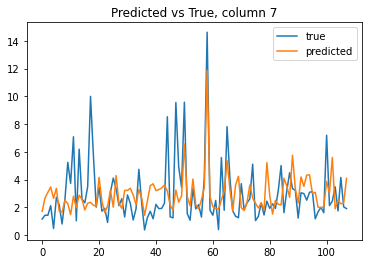

In [14]:
# 对测试集进行测试
y_pred = model.predict(X_test)

# 反归一化
#scaler.fit(y_test)
y_test = scaler_y.inverse_transform(y_test)
y_pred = scaler_y.inverse_transform(y_pred)

# 绘制预测值和真实值的对比图
for i in range(y_test.shape[1]):
    plt.plot(y_test[:, i], label='true')
    plt.plot(y_pred[:, i], label='predicted')
    plt.legend()
    plt.title(f"Predicted vs True, column {i+1}")
    plt.show()



Dimension 1: MSE = 13.506285141689453, RMSE = 3.6750898140983512, MAE = 2.053329057219728
Dimension 2: MSE = 1429.4845906389965, RMSE = 37.80852536980246, MAE = 25.982776321495564
Dimension 3: MSE = 15282.484830563799, RMSE = 123.6223476179117, MAE = 95.3640081117138
Dimension 4: MSE = 6915.004211396961, RMSE = 83.15650432405731, MAE = 66.51163586918966
Dimension 5: MSE = 6390.157172928972, RMSE = 79.93845865995273, MAE = 63.834676598423876
Dimension 6: MSE = 8154.640809689988, RMSE = 90.30304983603814, MAE = 69.55645269768249
Dimension 7: MSE = 3209.994063105609, RMSE = 56.656809503409285, MAE = 41.83501008641383


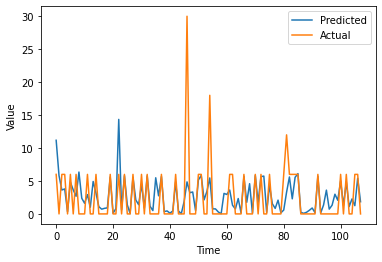

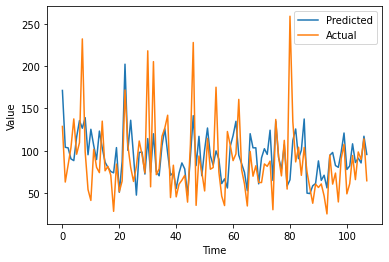

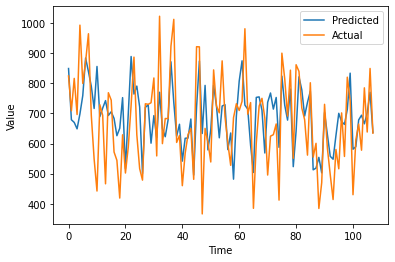

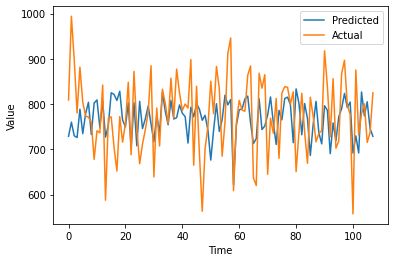

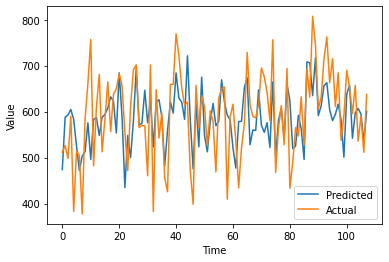

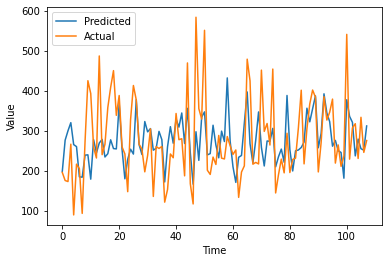

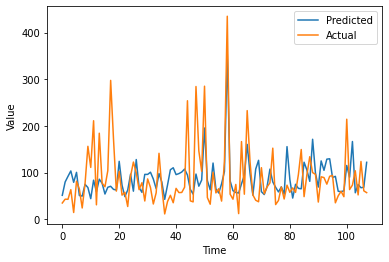

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)
df = pd.read_csv("/root/2023mcm/result.csv")
# Create the "GRU" column and assign the predicted values to it
# 计算每个维度的 MSE、RMSE 和 MAE
for i in range(7):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    print("Dimension {}: MSE = {}, RMSE = {}, MAE = {}".format(i+1, mse, rmse, mae))
# 将每个维度的预测值和实际值都分别可视化
for i in range(7):
    plt.plot(y_pred[:, i], label="Predicted")
    plt.plot(y_test[:, i], label="Actual")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

In [16]:
import stats
#对于给定的输入 X，进行预测
X_new = np.array([[620,0, 1, 0, 3, 1, 1, 1,0.09318,0.063]]) # 举例子
X_new = scaler_X.transform(X_new) # 归一化
# 预测
y_pred = model.predict(X_new)

# 反归一化
y_pred_orig = scaler_y.inverse_transform(y_pred)

# 打印预测结果
print("预测结果：")
print(y_pred_orig)

预测结果：
[[ 0.18193915  5.30386837 23.0750573  34.5033332  24.02811888 10.59646525
   1.96775963]]


In [ ]:
from scipy import stats

def get_confidence_interval(model, X, alpha=0.05):
    """
    给定模型和输入，计算预测值和置信区间
    :param model: 已训练的模型
    :param X: 输入，形状为 (n_samples, n_features)
    :param alpha: 置信水平，默认为 0.05
    :return: 预测值、置信区间下界、置信区间上界
    """
    model.eval() # 模型评估模式
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device) # 转换为张量并放到 GPU 上（如果有）
        y_pred = model(X_tensor).cpu().numpy() # 将预测值转换为 numpy 数组
        n_samples = len(X)
        df = n_samples - model.hidden_size - 1 # 自由度
        se = np.sqrt(np.sum((model(X_tensor).cpu().numpy() - y)**2) / df) # 标准误差
        t = stats.t.ppf(1 - alpha/2, df) # t 分布的分位数
        lower = y_pred - t * se # 置信区间下界
        upper = y_pred + t * se # 置信区间上界
    return y_pred, lower, upper

y_pred, lower, upper = get_confidence_interval(model, X_new)
print("预测值为：", y_pred)
print("置信区间为：[{}, {}]".format(lower, upper))